### Netflix Data Visualization

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder.appName("Netflix Data Analysis").getOrCreate()

In [1]:
! pwd

/app


In [4]:
df = spark.read.csv(
    "/app/data/netflix_titles.csv",
    header=True,
    inferSchema=True,
)
df.show(3)

+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|     s1|  Movie|Dick Johnson Is Dead|Kirsten Johnson|                null|United States|September 25, 2021|        2020| PG-13|   90 min|       Documentaries|As her father nea...|
|     s2|TV Show|       Blood & Water|           null|Ama Qamata, Khosi...| South Africa|September 24, 2021|        2021| TV-MA|2 Seasons|International TV ...|After crossing pa...|
|     s3|TV Show|           Ganglands|Julien Leclercq|Sami Bouajila, Tr...|         null|Septem

In [5]:
print(f"Number of rows: {df.count()}")
print(f"Number of columns: {len(df.columns)}")

Number of rows: 8809
Number of columns: 12


In [6]:
df_columns = df.columns
df_columns

['show_id',
 'type',
 'title',
 'director',
 'cast',
 'country',
 'date_added',
 'release_year',
 'rating',
 'duration',
 'listed_in',
 'description']

In [7]:
df.printSchema()

root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)



### Dealing with the missing data

This is always scenario dependant, but in this case, I will:
- replace blank countries with the mode (most common) country
- keep director as it could be interesting to look at a certain director's films
- keep cast as it could be interesting to look at a certain cast's films

In [8]:
for column in df.columns:
    # Calculate the null rate for each column
    null_count = df.filter(F.col(column).isNull()).count()
    total_count = df.count()
    null_rate = (null_count / total_count) * 100

    if null_rate > 0:
        print(f"{column} null rate: {round(null_rate, 2)}%")

type null rate: 0.01%


title null rate: 0.02%
director null rate: 29.92%
cast null rate: 9.38%
country null rate: 9.44%
date_added null rate: 0.15%
release_year null rate: 0.02%


rating null rate: 0.07%
duration null rate: 0.06%
listed_in null rate: 0.03%
description null rate: 0.03%


In [9]:
# Replace null values in 'country' with the mode value
mode_country = df.groupby("country").count().orderBy(F.desc("count")).first()[0]
df = df.fillna({"country": mode_country})

# Replace null values in 'cast' and 'director' with "No Data"
df = df.fillna({"cast": "No Data", "director": "No Data"})

In [10]:
# Convert the 'date_added' column to a date format
df = df.withColumn("date_added", F.to_date(df["date_added"], "MMMM dd, yyyy"))

# Extract the month, month name, and year from the 'date_added' column
df = df.withColumn("month_added", F.month(df["date_added"]))
df = df.withColumn("month_name_added", F.date_format(df["date_added"], "MMMM"))
df = df.withColumn("year_added", F.year(df["date_added"]))

df.show(3)

+-------+-------+--------------------+---------------+--------------------+-------------+----------+------------+------+---------+--------------------+--------------------+-----------+----------------+----------+
|show_id|   type|               title|       director|                cast|      country|date_added|release_year|rating| duration|           listed_in|         description|month_added|month_name_added|year_added|
+-------+-------+--------------------+---------------+--------------------+-------------+----------+------------+------+---------+--------------------+--------------------+-----------+----------------+----------+
|     s1|  Movie|Dick Johnson Is Dead|Kirsten Johnson|             No Data|United States|2021-09-25|        2020| PG-13|   90 min|       Documentaries|As her father nea...|          9|       September|      2021|
|     s2|TV Show|       Blood & Water|        No Data|Ama Qamata, Khosi...| South Africa|2021-09-24|        2021| TV-MA|2 Seasons|International TV .

### Handle wrong movies types

In [11]:
df.select("type").distinct().show()

+-------------+
|         type|
+-------------+
|         null|
|      TV Show|
|        Movie|
|William Wyler|
+-------------+



In [12]:
allowed_values = ["TV Show", "Movie"]

In [13]:
df = df.filter(df["type"].isin(allowed_values))

In [14]:
df.show(10)

+-------+-------+--------------------+--------------------+--------------------+--------------------+----------+------------+------+---------+--------------------+--------------------+-----------+----------------+----------+
|show_id|   type|               title|            director|                cast|             country|date_added|release_year|rating| duration|           listed_in|         description|month_added|month_name_added|year_added|
+-------+-------+--------------------+--------------------+--------------------+--------------------+----------+------------+------+---------+--------------------+--------------------+-----------+----------------+----------+
|     s1|  Movie|Dick Johnson Is Dead|     Kirsten Johnson|             No Data|       United States|2021-09-25|        2020| PG-13|   90 min|       Documentaries|As her father nea...|          9|       September|      2021|
|     s2|TV Show|       Blood & Water|             No Data|Ama Qamata, Khosi...|        South Africa

### Visualization

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
import warnings

warnings.filterwarnings("ignore")

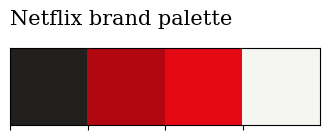

In [16]:
# Palette
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])

plt.title("Netflix brand palette ",loc='left',fontfamily='serif',fontsize=15,y=1.2)
plt.show()

#### Netflix through the years

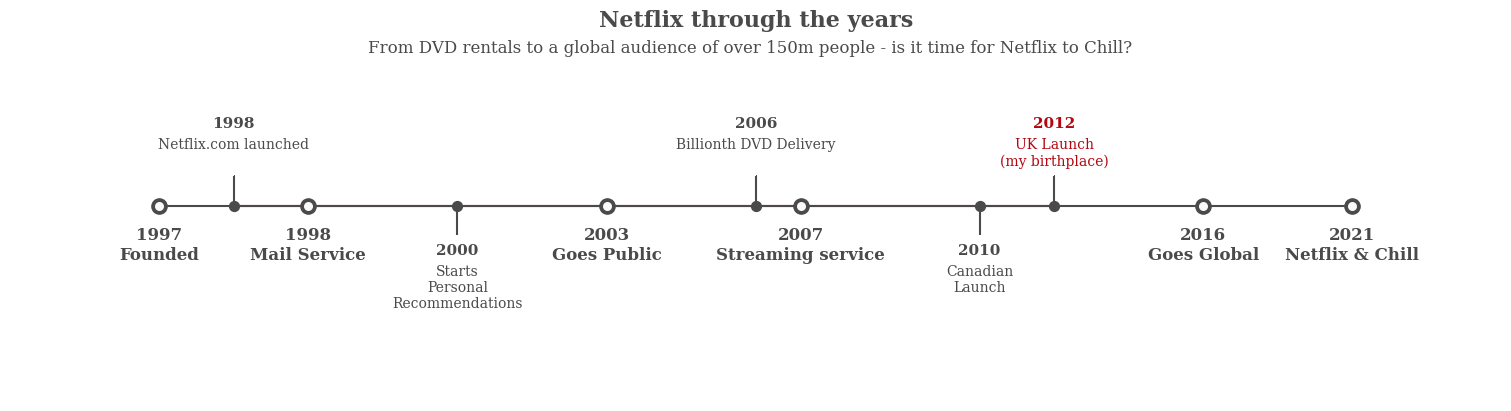

In [17]:
## these go on the numbers below
tl_dates = [
    "1997\nFounded",
    "1998\nMail Service",
    "2003\nGoes Public",
    "2007\nStreaming service",
    "2016\nGoes Global",
    "2021\nNetflix & Chill"
]

tl_x = [1, 2, 4, 5.3, 8,9]

## these go on the numbers
tl_sub_x = [1.5,3,5,6.5,7]


tl_sub_times = [
    "1998","2000","2006","2010","2012"
]

tl_text = [
    "Netflix.com launched",
    "Starts\nPersonal\nRecommendations","Billionth DVD Delivery","Canadian\nLaunch","UK Launch\n(my birthplace)"]



# Set figure & Axes
fig, ax = plt.subplots(figsize=(15, 4), constrained_layout=True)
ax.set_ylim(-2, 1.75)
ax.set_xlim(0, 10)


# Timeline : line
ax.axhline(0, xmin=0.1, xmax=0.9, c='#4a4a4a', zorder=1)


# Timeline : Date Points
ax.scatter(tl_x, np.zeros(len(tl_x)), s=120, c='#4a4a4a', zorder=2)
ax.scatter(tl_x, np.zeros(len(tl_x)), s=30, c='#fafafa', zorder=3)
# Timeline : Time Points
ax.scatter(tl_sub_x, np.zeros(len(tl_sub_x)), s=50, c='#4a4a4a',zorder=4)

# Date Text
for x, date in zip(tl_x, tl_dates):
    ax.text(x, -0.55, date, ha='center', 
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a',fontsize=12)
    

# Stemplot : vertical line
levels = np.zeros(len(tl_sub_x))    
levels[::2] = 0.3
levels[1::2] = -0.3
markerline, stemline, baseline = ax.stem(tl_sub_x, levels)    
plt.setp(baseline, zorder=0)
plt.setp(markerline, marker=',', color='#4a4a4a')
plt.setp(stemline, color='#4a4a4a')

# Text
for idx, x, time, txt in zip(range(1, len(tl_sub_x)+1), tl_sub_x, tl_sub_times, tl_text):
    ax.text(x, 1.3*(idx%2)-0.5, time, ha='center', 
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a' if idx!=len(tl_sub_x) else '#b20710', fontsize=11)
    
    ax.text(x, 1.3*(idx%2)-0.6, txt, va='top', ha='center', 
        fontfamily='serif',color='#4a4a4a' if idx!=len(tl_sub_x) else '#b20710')



# Spine
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

# Ticks    
ax.set_xticks([]) 
ax.set_yticks([]) 

# Title
ax.set_title("Netflix through the years", fontweight="bold", fontfamily='serif', fontsize=16, color='#4a4a4a')
ax.text(2.4,1.57,"From DVD rentals to a global audience of over 150m people - is it time for Netflix to Chill?", fontfamily='serif', fontsize=12, color='#4a4a4a')

plt.show()

#### Movie & TV Show distribution

In [18]:
df.columns

['show_id',
 'type',
 'title',
 'director',
 'cast',
 'country',
 'date_added',
 'release_year',
 'rating',
 'duration',
 'listed_in',
 'description',
 'month_added',
 'month_name_added',
 'year_added']

In [24]:
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")
pandas_df = pd.DataFrame(df.collect(), columns = df.columns)

In [25]:
pandas_df.set_index("show_id", inplace=True)

In [26]:
pandas_df.columns

Index(['type', 'title', 'director', 'cast', 'country', 'date_added',
       'release_year', 'rating', 'duration', 'listed_in', 'description',
       'month_added', 'month_name_added', 'year_added'],
      dtype='object')

In [27]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8807 entries, s1 to s8807
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   type              8807 non-null   object 
 1   title             8807 non-null   object 
 2   director          8807 non-null   object 
 3   cast              8807 non-null   object 
 4   country           8807 non-null   object 
 5   date_added        8689 non-null   object 
 6   release_year      8806 non-null   object 
 7   rating            8802 non-null   object 
 8   duration          8803 non-null   object 
 9   listed_in         8806 non-null   object 
 10  description       8806 non-null   object 
 11  month_added       8689 non-null   float64
 12  month_name_added  8689 non-null   object 
 13  year_added        8689 non-null   float64
dtypes: float64(2), object(12)
memory usage: 1.0+ MB


In [28]:
x=pandas_df.groupby(['type'])['type'].count()
y=len(pandas_df)
r=((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T

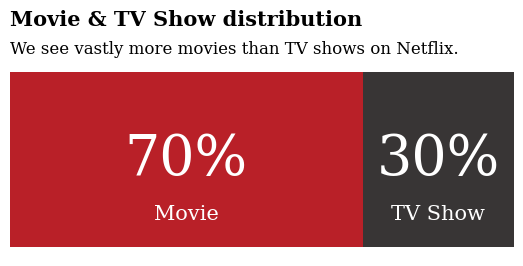

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6.5, 2.5))

ax.barh(mf_ratio.index, mf_ratio['Movie'], 
        color='#b20710', alpha=0.9, label='Male')
ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'], 
        color='#221f1f', alpha=0.9, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
#ax.set_yticklabels(mf_ratio.index, fontfamily='serif', fontsize=11)


# movie percentage
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Movie'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie", 
                   xy=(mf_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['TV Show'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')


# Title & Subtitle
fig.text(0.125,1.03,'Movie & TV Show distribution', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'We see vastly more movies than TV shows on Netflix.',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    


#ax.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.06))

# Removing legend due to labelled plot
ax.legend().set_visible(False)
plt.show()

#### Netflix by Country

In [30]:
# Quick feature engineering

# Helper column for various plots
pandas_df['count'] = 1

# Lets retrieve just the first country
pandas_df['first_country'] = pandas_df['country'].apply(lambda x: x.split(",")[0])
pandas_df['first_country'].head()

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

pandas_df['target_ages'] = pandas_df['rating'].replace(ratings_ages)
pandas_df['target_ages'].unique()

# Genre
pandas_df['listed_in'] = pandas_df['listed_in'].fillna('')
pandas_df['genre'] = pandas_df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 

# Reducing name length

pandas_df["first_country"] = pandas_df["first_country"].replace(
    {"United States": "USA", "United Kingdom": "UK", "South Korea": "S. Korea"}
)

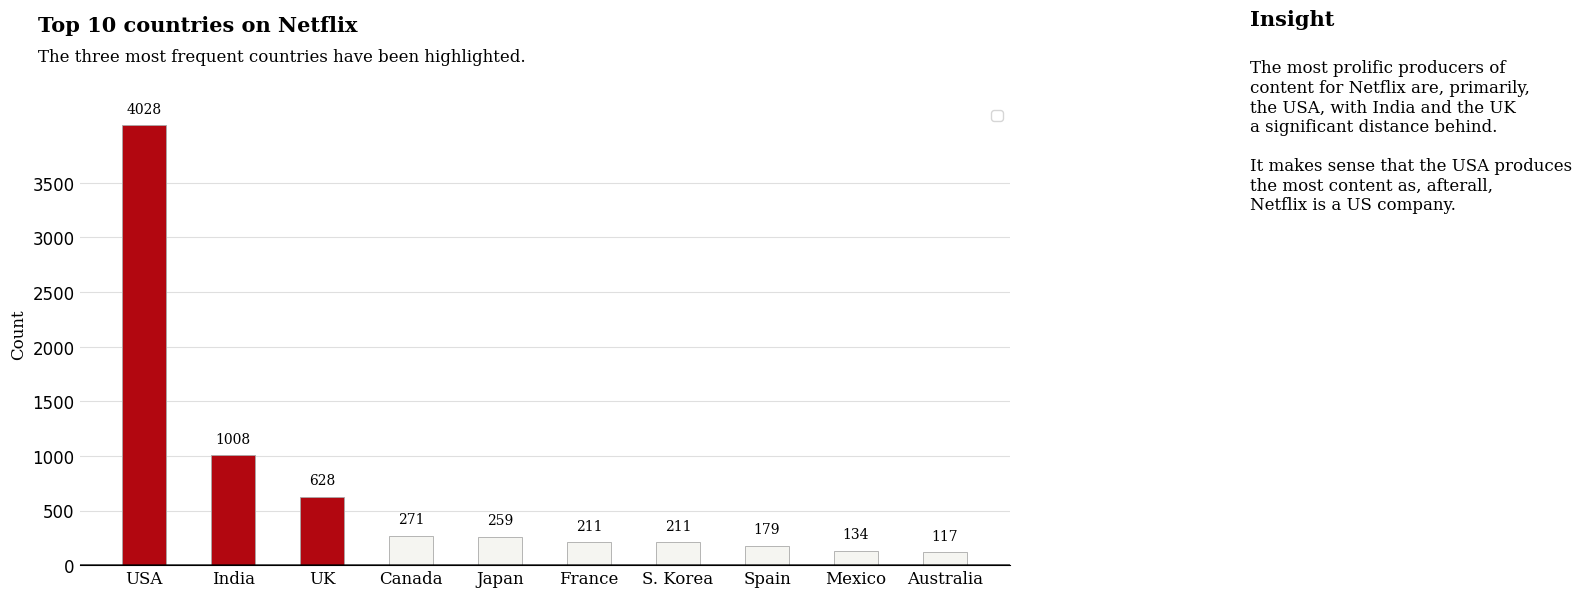

In [38]:
data = pandas_df.groupby('first_country')['count'].sum().sort_values(ascending=False)[:10]

# Plot

color_map = ['#f5f5f1' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#b20710' # color highlight

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(data.index, data, width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6,color=color_map)

#annotations
for i in data.index:
    ax.annotate(f"{data[i]}", 
                   xy=(i, data[i] + 150), #i like to change this to roughly 5% of the highest cat
                   va = 'center', ha='center',fontweight='light', fontfamily='serif')

# Remove border from plot

for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Tick labels
ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

# Title and sub-title
fig.text(0.09, 1, 'Top 10 countries on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The three most frequent countries have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.1, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')

fig.text(1.1, 0.67, '''
The most prolific producers of
content for Netflix are, primarily,
the USA, with India and the UK
a significant distance behind.

It makes sense that the USA produces 
the most content as, afterall, 
Netflix is a US company.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)   

grid_y_ticks = np.arange(0, 4000, 500) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

#Axis labels

plt.ylabel("Count", fontsize=12, fontweight='light', fontfamily='serif')
plt.legend(loc='upper right')
    
# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

ax.tick_params(axis='both', which='major', labelsize=12)

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

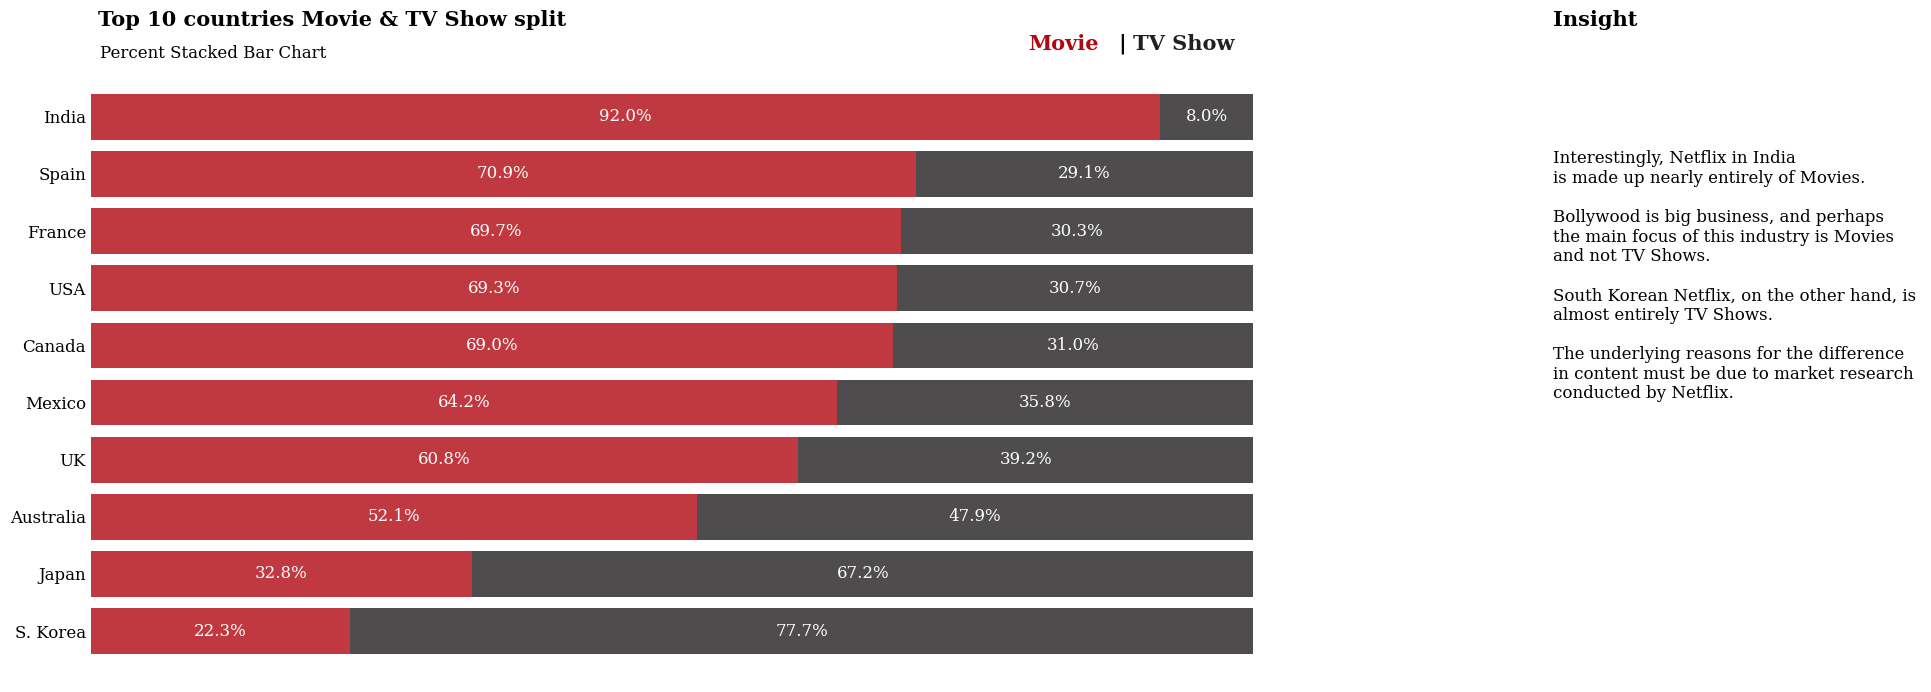

In [49]:
# Get the top 10 countries
country_order = pandas_df['first_country'].value_counts()[:10].index

# Grouping and counting types
data_q2q3 = pandas_df[['type', 'first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3.fillna(0, inplace=True)  # Fill NaN values with 0
data_q2q3['sum'] = data_q2q3.sum(axis=1)

# Calculate ratios
data_q2q3_ratio = (data_q2q3.T / (data_q2q3['sum'] + 1e-10)).T[['Movie', 'TV Show']].sort_values(by='Movie', ascending=False)[::-1]

# Create the horizontal stacked bar chart
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#221f1f', alpha=0.8, label='TV Show')

# Set limits and labels
ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# Annotations for Movie percentages
for i in data_q2q3_ratio.index:
    ax.annotate(
        f"{data_q2q3_ratio['Movie'][i] * 100:.1f}%",
        xy=(data_q2q3_ratio["Movie"][i] / 2, i),
        va="center",
        ha="center",
        fontsize=12,
        fontweight="light",
        fontfamily="serif",
        color="white",
    )

# Annotations for TV Show percentages
for i in data_q2q3_ratio.index:
    ax.annotate(
        f"{data_q2q3_ratio['TV Show'][i] * 100:.1f}%",
        xy=(data_q2q3_ratio["Movie"][i] + data_q2q3_ratio["TV Show"][i] / 2, i),
        va="center",
        ha="center",
        fontsize=12,
        fontweight="light",
        fontfamily="serif",
        color="white",
    )

# Title and descriptions
fig.text(
    0.13,
    0.93,
    "Top 10 countries Movie & TV Show split",
    fontsize=15,
    fontweight="bold",
    fontfamily="serif",
)
fig.text(0.131, 0.89, "Percent Stacked Bar Chart", fontsize=12, fontfamily="serif")

# Hide spines
for s in ["top", "left", "right", "bottom"]:
    ax.spines[s].set_visible(False)

# Legend text for Movie and TV Show
fig.text(
    0.75,
    0.9,
    "Movie",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    color="#b20710",
)
fig.text(
    0.81, 0.9, "|", fontweight="bold", fontfamily="serif", fontsize=15, color="black"
)
fig.text(
    0.82,
    0.9,
    "TV Show",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    color="#221f1f",
)

# Insight text
fig.text(1.1, 0.93, "Insight", fontsize=15, fontweight="bold", fontfamily="serif")
fig.text(
    1.1,
    0.44,
    """
Interestingly, Netflix in India
is made up nearly entirely of Movies. 

Bollywood is big business, and perhaps
the main focus of this industry is Movies
and not TV Shows.

South Korean Netflix, on the other hand, is 
almost entirely TV Shows.

The underlying reasons for the difference 
in content must be due to market research
conducted by Netflix.
""",
    fontsize=12,
    fontweight="light",
    fontfamily="serif",
)

# Adjust tick parameters
ax.tick_params(axis="both", which="major", labelsize=12)
ax.tick_params(axis="both", which="both", length=0)

# Show the plot
plt.show()

### Ratings Distribution by Films & TV-Shows

In [41]:
order = pd.DataFrame(pandas_df.groupby('rating')['count'].sum().sort_values(ascending=False).reset_index())
rating_order = list(order['rating'])

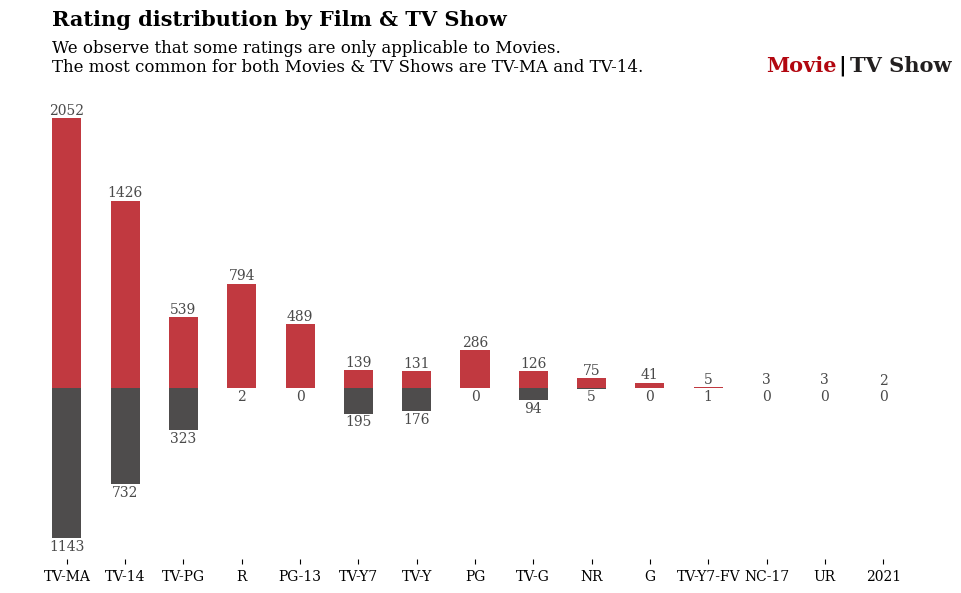

In [46]:
# Grouping and counting ratings
mf = (
    pandas_df.groupby("type")["rating"]
    .value_counts()
    .unstack()
    .sort_index()
    .fillna(0)
    .astype(int)[rating_order]
)

# Separating Movie and TV Show Data
movie = mf.loc["Movie"]
tv = -mf.loc["TV Show"]

# Create a mask for filtering out specific conditions
mask = ~((movie <= 1) & (tv >= -1))

# Filter the movie and tv Series based on the mask
filtered_movie = movie[mask]
filtered_tv = tv[mask]

# Creating the bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.bar(
    filtered_movie.index,
    filtered_movie,
    width=0.5,
    color="#b20710",
    alpha=0.8,
    label="Movie",
)
ax.bar(
    filtered_tv.index,
    filtered_tv,
    width=0.5,
    color="#221f1f",
    alpha=0.8,
    label="TV Show",
)

# Annotations
for i in filtered_tv.index:
    ax.annotate(
        f"{-filtered_tv[i]}",
        xy=(i, filtered_tv[i] - 60),
        va="center",
        ha="center",
        fontweight="light",
        fontfamily="serif",
        color="#4a4a4a",
    )

for i in filtered_movie.index:
    ax.annotate(
        f"{filtered_movie[i]}",
        xy=(i, filtered_movie[i] + 60),
        va="center",
        ha="center",
        fontweight="light",
        fontfamily="serif",
        color="#4a4a4a",
    )

# Customizing the plot
for s in ["top", "left", "right", "bottom"]:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily="serif")
ax.set_yticks([])

ax.legend().set_visible(False)
fig.text(
    0.16,
    1,
    "Rating distribution by Film & TV Show",
    fontsize=15,
    fontweight="bold",
    fontfamily="serif",
)
fig.text(
    0.16,
    0.89,
    """We observe that some ratings are only applicable to Movies. 
The most common for both Movies & TV Shows are TV-MA and TV-14.
""",
    fontsize=12,
    fontweight="light",
    fontfamily="serif",
)

fig.text(
    0.755,
    0.924,
    "Movie",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    color="#b20710",
)
fig.text(
    0.815, 0.924, "|", fontweight="bold", fontfamily="serif", fontsize=15, color="black"
)
fig.text(
    0.825,
    0.924,
    "TV Show",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    color="#221f1f",
)

plt.show()

#### How has content been added over the years?

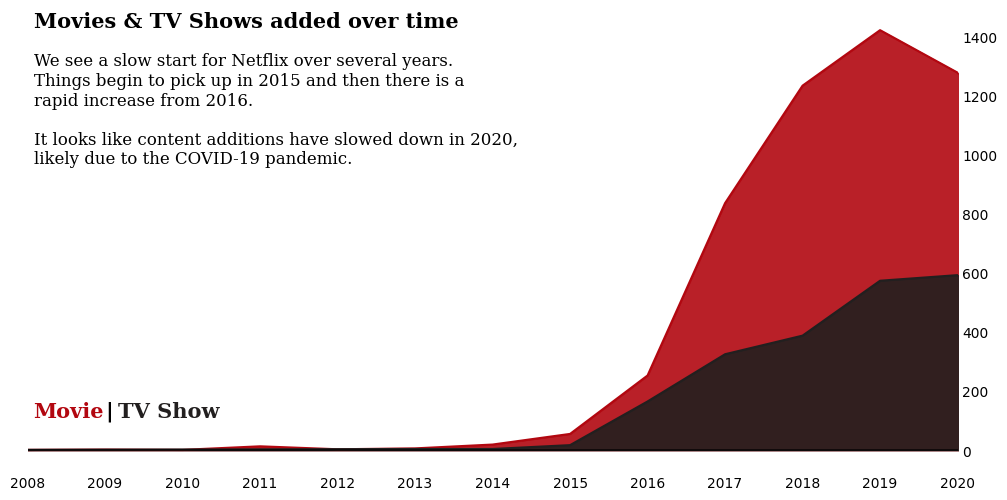

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(pandas_df['type'].value_counts().index):
    mtv_rel = pandas_df[pandas_df['type']==mtv]['year_added'].value_counts().sort_index()
    ax.plot(mtv_rel.index, mtv_rel, color=color[i], label=mtv)
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], alpha=0.9)
    
ax.yaxis.tick_right()
    
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'Movies & TV Shows added over time', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.59, 
'''We see a slow start for Netflix over several years. 
Things begin to pick up in 2015 and then there is a 
rapid increase from 2016.

It looks like content additions have slowed down in 2020, 
likely due to the COVID-19 pandemic.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.13,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

#### Content added by month [Cumulative Total]

In [51]:
month_order = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

pandas_df['month_name_added'] = pd.Categorical(pandas_df['month_name_added'], categories=month_order, ordered=True)

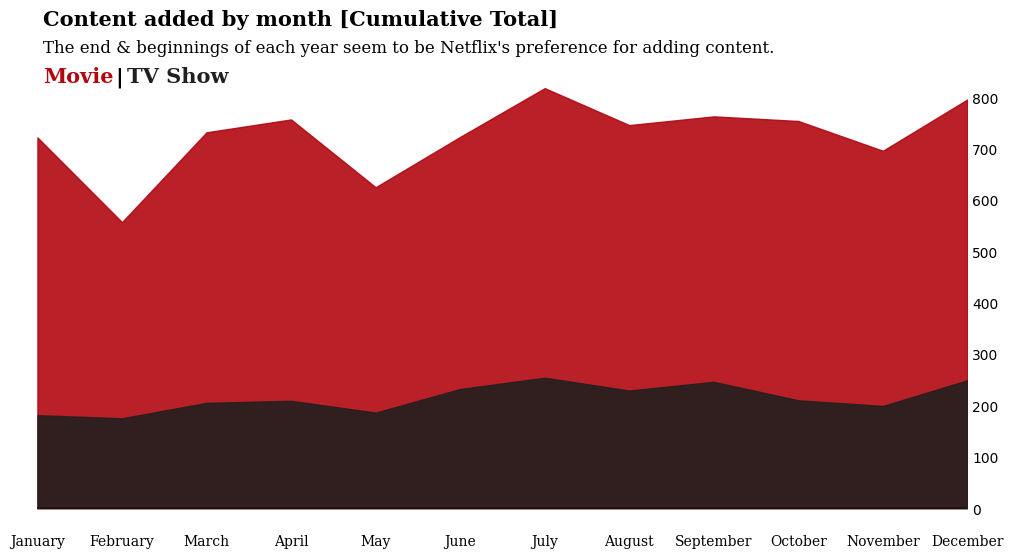

In [52]:
data_sub = pandas_df.groupby('type')['month_name_added'].value_counts().unstack().fillna(0).loc[['TV Show','Movie']].cumsum(axis=0).T

fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(pandas_df['type'].value_counts().index):
    mtv_rel = data_sub[mtv]
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], label=mtv,alpha=0.9)
    
ax.yaxis.tick_right()
    
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .4)

for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)

ax.grid(False)
ax.set_xticklabels(data_sub.index, fontfamily='serif', rotation=0)
ax.margins(x=0) # remove white spaces next to margins


fig.text(0.13, 0.95, 'Content added by month [Cumulative Total]', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.905, 
"The end & beginnings of each year seem to be Netflix's preference for adding content."

, fontsize=12, fontweight='light', fontfamily='serif')



fig.text(0.13,0.855,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.855,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.855,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

#### How content is added across the year?

In [95]:
data_sub2 = data_sub

data_sub2['Value'] = data_sub2['Movie'] + data_sub2['TV Show']
data_sub2 = data_sub2.reset_index()

df_polar = data_sub2.sort_values(by='month_name_added',ascending=False)


color_map = ['#221f1f' for _ in range(12)]
color_map[0] = color_map[11] =  '#b20710' # color highlight


# initialize the figure
plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 30
lowerLimit = 1
labelPadding = 30

# Compute max and min in the dataset
max = df_polar['Value'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max - lowerLimit) / max
heights = slope * df_polar.Value + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(df_polar.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(df_polar.index)+1))
angles = [element * width for element in indexes]

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color=color_map,alpha=0.8
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, df_polar["month_name_added"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, fontsize=10,fontfamily='serif',
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor")

KeyError: 'Movie'

Yes, December & January are definitely the best months for new content. Maybe Netflix knows that people have a lot of time off from work over this period and that it is a good time to reel people in?

#### Movie Genres

In [56]:
import matplotlib.colors
from sklearn.preprocessing import MultiLabelBinarizer

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list(
    "", ["#221f1f", "#b20710", "#f5f5f1"]
)


def genre_heatmap(pandas_df, title):
    """
    Generate a heatmap showing the correlation between different genres in the Netflix dataset.

    Parameters:
    pandas_df (DataFrame): The DataFrame containing Netflix data with a 'listed_in' column.
    title (str): Title for the dataset being analyzed.
    """
    # Extract genres from the 'listed_in' column
    pandas_df["genre"] = pandas_df["listed_in"].apply(
        lambda x: x.replace(" ,", ",").replace(", ", ",").split(",")
    )

    # Create a set of unique genres
    Types = []
    for i in pandas_df["genre"]:
        Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types), title))

    # Transform genres into a binary format
    test = pandas_df["genre"]
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)

    # Calculate the correlation matrix
    corr = res.corr()

    # Create a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the heatmap plot
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.text(
        0.54,
        0.88,
        "Genre Correlation",
        fontfamily="serif",
        fontweight="bold",
        fontsize=15,
    )
    fig.text(
        0.75,
        0.665,
        """
             It is interesting that Independent Movies
             tend to be Dramas. 
             
             Another observation is that 
             International Movies are rarely
             in the Children's genre.
             """,
        fontfamily="serif",
        fontsize=12,
        ha="right",
    )

    # Draw the heatmap
    pl = sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=0.3,
        vmin=-0.3,
        center=0,
        square=True,
        linewidths=2.5,
    )

    # Show the plot
    plt.show()

There are 40 types in the Netflix Movie Dataset


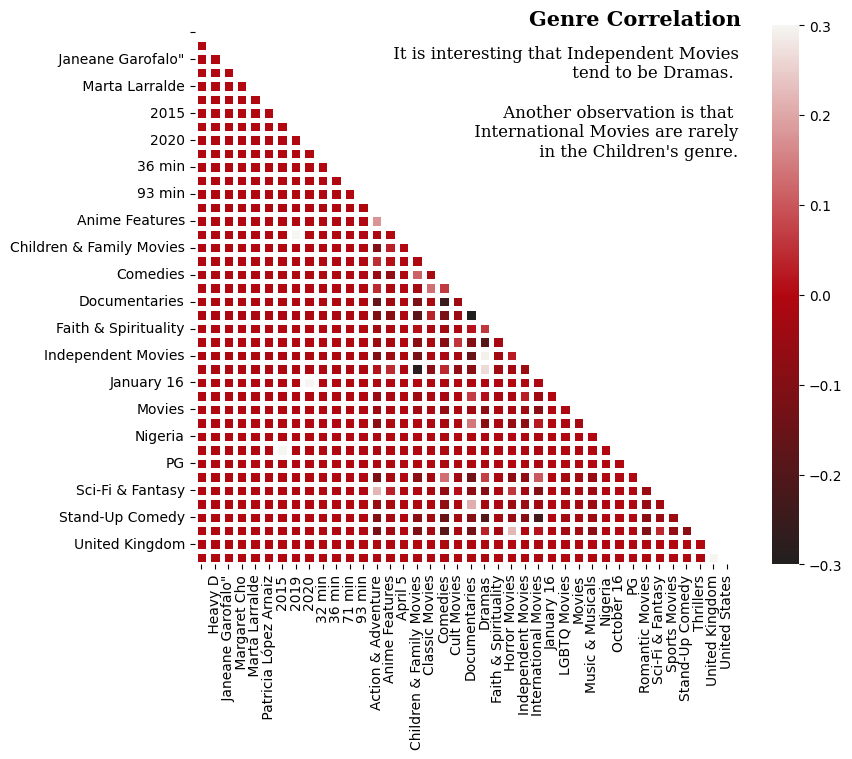

In [57]:
df_tv = pandas_df[pandas_df["type"] == "TV Show"]
df_movies = pandas_df[pandas_df["type"] == "Movie"]


genre_heatmap(df_movies, 'Movie')
plt.show()

In [80]:
top_countries = (
    pandas_df.groupby("first_country")["count"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)
top_country_names = top_countries.index

df_heatmap = pandas_df[pandas_df["first_country"].isin(top_country_names)]

In [81]:
df_heatmap = pd.crosstab(
    df_heatmap["first_country"], df_heatmap["target_ages"], normalize="index"
).T

#### Target Ages

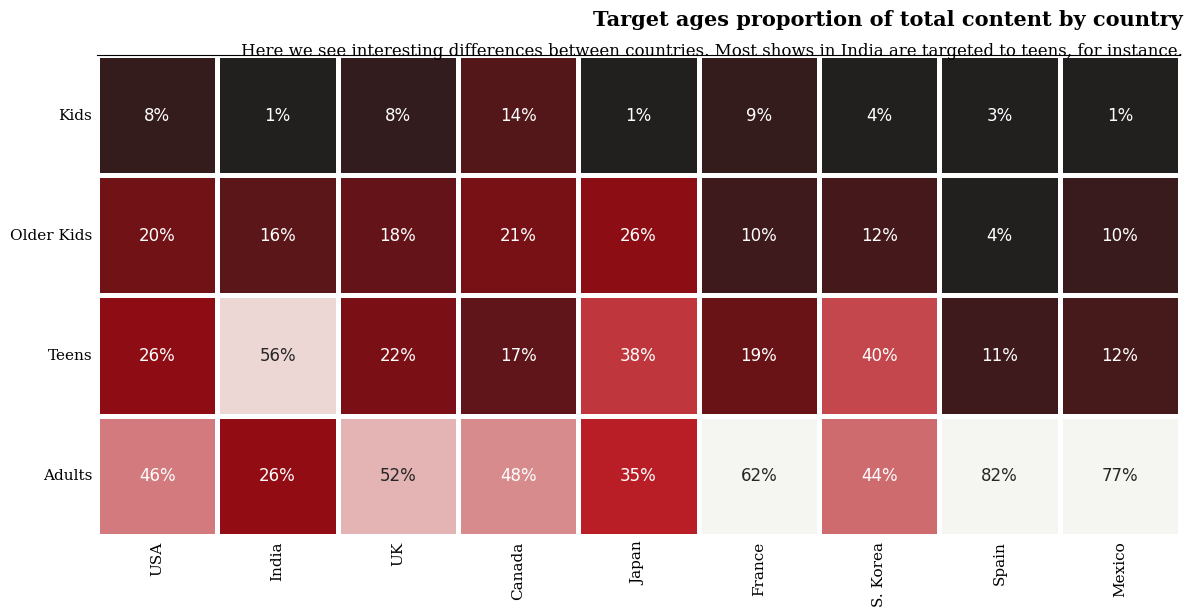

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

country_order2 = [
    "USA",
    "India",
    "UK",
    "Canada",
    "Japan",
    "France",
    "S. Korea",
    "Spain",
    "Mexico",
]

age_order = ["Kids", "Older Kids", "Teens", "Adults"]

sns.heatmap(
    df_heatmap.loc[age_order, country_order2],
    cmap=cmap,
    square=True,
    linewidth=2.5,
    cbar=False,
    annot=True,
    fmt="1.0%",
    vmax=0.6,
    vmin=0.05,
    ax=ax,
    annot_kws={"fontsize": 12},
)

ax.spines["top"].set_visible(True)


fig.text(
    0.99,
    0.725,
    "Target ages proportion of total content by country",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    ha="right",
)
fig.text(
    0.99,
    0.7,
    "Here we see interesting differences between countries. Most shows in India are targeted to teens, for instance.",
    ha="right",
    fontsize=12,
    fontfamily="serif",
)

ax.set_yticklabels(ax.get_yticklabels(), fontfamily="serif", rotation=0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily="serif", rotation=90, fontsize=11)

ax.set_ylabel("")
ax.set_xlabel("")
ax.tick_params(axis="both", which="both", length=0)
plt.tight_layout()
plt.show()

#### lag between when content is released and when it is added on Netflix

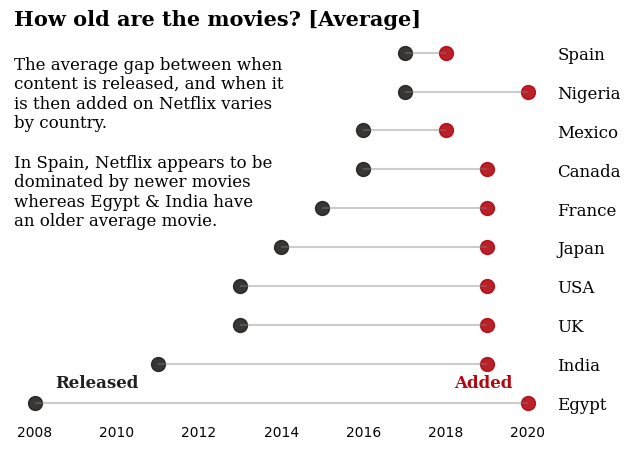

In [66]:
# Relevant groupings
data = df_movies.groupby('first_country')[['count']].sum().sort_values(by='count', ascending=False).reset_index()[:10]
data = data['first_country']
df_loli = df_movies.loc[df_movies['first_country'].isin(data)]

# Group by first_country and calculate the mean of release_year and year_added
df_loli["release_year"] = pd.to_numeric(df_loli["release_year"], errors="coerce")
df_loli["year_added"] = pd.to_numeric(df_loli["year_added"], errors="coerce")
loli = df_loli.groupby('first_country')[['release_year', 'year_added']].mean().round()

# Reorder it following the values of the first value
ordered_df = loli.sort_values(by='release_year')

# Create a range for plotting
my_range = range(1, len(ordered_df.index) + 1)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

# Title
fig.text(0.13, 0.9, 'How old are the movies? [Average]', fontsize=15, fontweight='bold', fontfamily='serif')

# Plot horizontal lines and scatter points
plt.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year_added'], color='grey', alpha=0.4)
plt.scatter(ordered_df['release_year'], my_range, color='#221f1f', s=100, alpha=0.9, label='Average release date')
plt.scatter(ordered_df['year_added'], my_range, color='#b20710', s=100, alpha=0.9, label='Average added date')

# Hide spines
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

# Removes the tick marks but keeps the labels
ax.tick_params(axis='both', which='both', length=0)
# Move Y axis to the right side
ax.yaxis.tick_right()

# Set y-ticks to the country names
plt.yticks(my_range, ordered_df.index)
plt.yticks(fontname="serif", fontsize=12)

# Custom legend
fig.text(0.19, 0.175, "Released", fontweight="bold", fontfamily='serif', fontsize=12, color='#221f1f')
fig.text(0.76, 0.175, "Added", fontweight="bold", fontfamily='serif', fontsize=12, color='#b20710')

# Insight text
fig.text(
    0.13,
    0.46,
    """The average gap between when 
content is released, and when it
is then added on Netflix varies
by country. 

In Spain, Netflix appears to be 
dominated by newer movies 
whereas Egypt & India have
an older average movie.
""",
    fontsize=12,
    fontweight="light",
    fontfamily="serif",
)

plt.show()

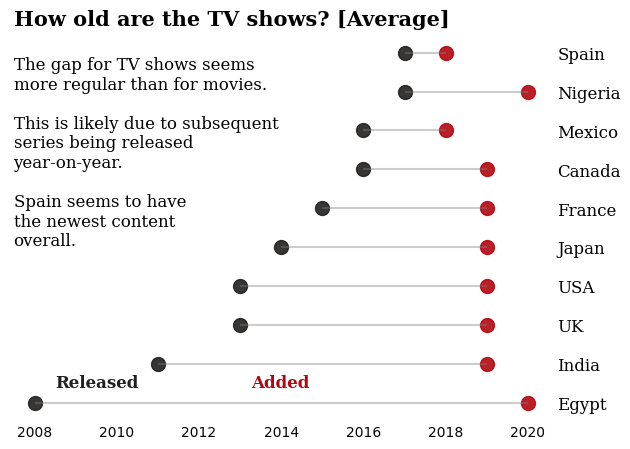

In [67]:
# Reorder it following the values of the first value:
ordered_df = loli.sort_values(by='release_year')

ordered_df_rev = loli.sort_values(by='release_year',ascending=False)

my_range=range(1,len(loli.index)+1)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

fig.text(0.13, 0.9, 'How old are the TV shows? [Average]', fontsize=15, fontweight='bold', fontfamily='serif')
plt.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year_added'], color='grey', alpha=0.4)
plt.scatter(ordered_df['release_year'], my_range, color='#221f1f',s=100, alpha=0.9, label='Average release date')
plt.scatter(ordered_df['year_added'], my_range, color='#b20710',s=100, alpha=0.9 , label='Average added date')
#plt.legend()

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
ax.yaxis.tick_right()
plt.yticks(my_range, ordered_df.index)
plt.yticks(fontname = "serif",fontsize=12)


fig.text(0.19,0.175,"Released", fontweight="bold", fontfamily='serif', fontsize=12, color='#221f1f')

fig.text(0.47,0.175,"Added", fontweight="bold", fontfamily='serif', fontsize=12, color='#b20710')


fig.text(0.13, 0.42, 
'''The gap for TV shows seems
more regular than for movies.

This is likely due to subsequent
series being released
year-on-year.

Spain seems to have
the newest content
overall.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


ax.tick_params(axis=u'both', which=u'both',length=0)
#plt.xlabel('Value of the variables')
#plt.ylabel('Group')
plt.show()

#### USA & India

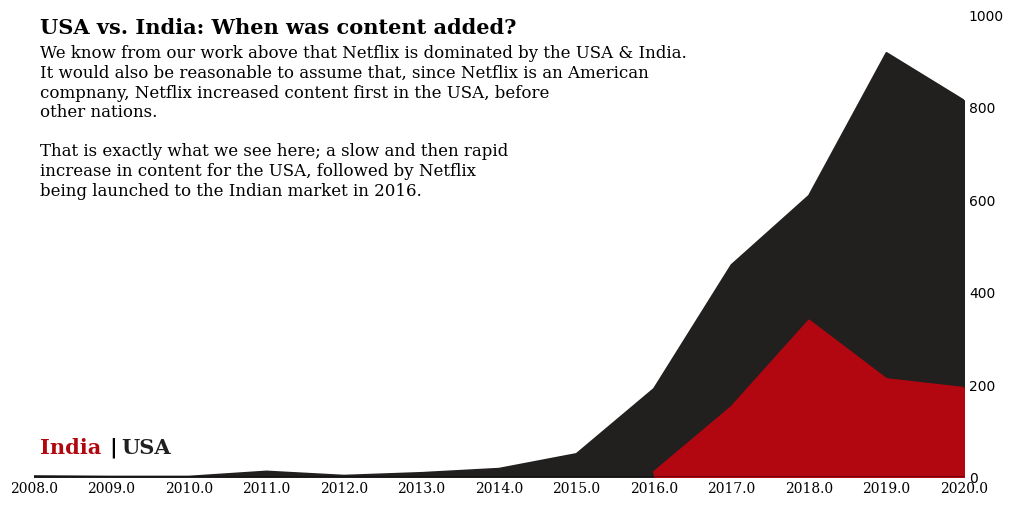

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
color = ["#221f1f", "#b20710", "#f5f5f1"]

for i, hs in enumerate(us_ind["first_country"].value_counts().index):
    hs_built = (
        us_ind[us_ind["first_country"] == hs]["year_added"].value_counts().sort_index()
    )
    ax.plot(hs_built.index, hs_built, color=color[i], label=hs)
    # ax.fill_between(hs_built.index, 0, hs_built, color=color[i], alpha=0.4)
    ax.fill_between(hs_built.index, 0, hs_built, color=color[i], label=hs)

ax.set_ylim(0, 1000)
# ax.legend(loc='upper left')
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

ax.yaxis.tick_right()

ax.axhline(y=0, color="black", linewidth=1.3, alpha=0.4)

# ax.set_ylim(0, 50)
# ax.legend(loc='upper left')
for s in ["top", "right", "bottom", "left"]:
    ax.spines[s].set_visible(False)

ax.grid(False)
ax.set_xticklabels(data_sub.index, fontfamily="serif", rotation=0)
ax.margins(x=0)  # remove white spaces next to margins

ax.set_xlim(2008, 2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(
    0.13,
    0.85,
    "USA vs. India: When was content added?",
    fontsize=15,
    fontweight="bold",
    fontfamily="serif",
)
fig.text(
    0.13,
    0.58,
    """
We know from our work above that Netflix is dominated by the USA & India.
It would also be reasonable to assume that, since Netflix is an American
compnany, Netflix increased content first in the USA, before 
other nations. 

That is exactly what we see here; a slow and then rapid
increase in content for the USA, followed by Netflix 
being launched to the Indian market in 2016.""",
    fontsize=12,
    fontweight="light",
    fontfamily="serif",
)

fig.text(
    0.13,
    0.15,
    "India",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    color="#b20710",
)
fig.text(
    0.188, 0.15, "|", fontweight="bold", fontfamily="serif", fontsize=15, color="black"
)
fig.text(
    0.198,
    0.15,
    "USA",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    color="#221f1f",
)

ax.tick_params(axis="both", which="both", length=0)


plt.show()

In [90]:
us_ind = pandas_df[(pandas_df['first_country'] == 'USA') | (pandas_df['first_country'] == 'India' )]

data_sub = pandas_df.groupby('first_country')['year_added'].value_counts().unstack().fillna(0).loc[['USA','India']].cumsum(axis=0).T
data_sub.insert(0, "base", np.zeros(len(data_sub)))

data_sub = data_sub.add(-us_ind['year_added'].value_counts()/2, axis=0)

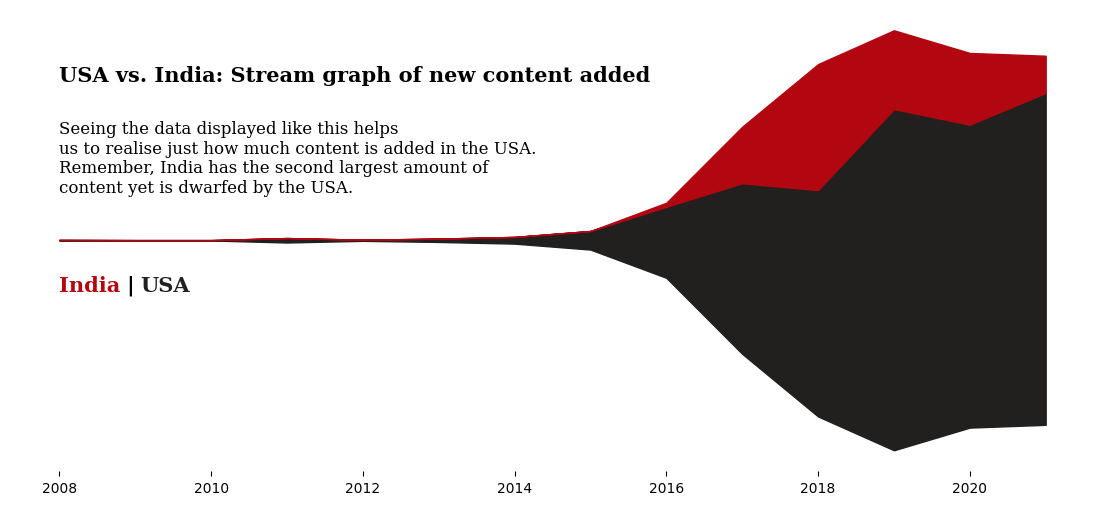

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
color = ["#b20710", "#221f1f"][::-1]
hs_list = data_sub.columns
hs_built = data_sub[hs]

for i, hs in enumerate(hs_list):
    if i == 0:
        continue
    ax.fill_between(
        hs_built.index, data_sub.iloc[:, i - 1], data_sub.iloc[:, i], color=color[i - 1]
    )

for s in ["top", "right", "bottom", "left"]:
    ax.spines[s].set_visible(False)
ax.set_axisbelow(True)
ax.set_yticks([])
# ax.legend(loc='upper left')
ax.grid(False)

fig.text(
    0.16,
    0.76,
    "USA vs. India: Stream graph of new content added",
    fontsize=15,
    fontweight="bold",
    fontfamily="serif",
)
fig.text(
    0.16,
    0.575,
    """
Seeing the data displayed like this helps 
us to realise just how much content is added in the USA.
Remember, India has the second largest amount of
content yet is dwarfed by the USA.""",
    fontsize=12,
    fontweight="light",
    fontfamily="serif",
)

fig.text(
    0.16,
    0.41,
    "India",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    color="#b20710",
)
fig.text(
    0.208, 0.41, "|", fontweight="bold", fontfamily="serif", fontsize=15, color="black"
)
fig.text(
    0.218,
    0.41,
    "USA",
    fontweight="bold",
    fontfamily="serif",
    fontsize=15,
    color="#221f1f",
)


ax.tick_params(axis="y", which="both", length=0)

plt.show()

#### Wordcloud to get an overview of Netflix titles

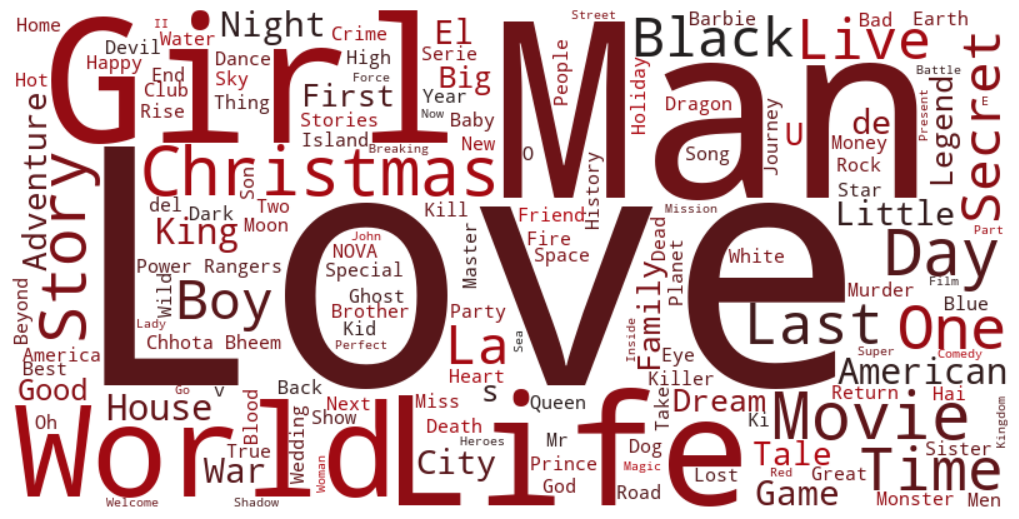

In [94]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt  # Make sure to import pyplot

# Custom colour map based on Netflix palette
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#221f1f", "#b20710"])

# Prepare the text for the word cloud
text = " ".join(pandas_df["title"].astype(str).tolist())  # Join titles with a space

# Generate the word cloud
wordcloud = WordCloud(
    background_color="white",
    width=800,  # Adjust width as needed
    height=400,  # Adjust height as needed
    colormap=cmap,
    max_words=150,
).generate(text)

# Display the word cloud
plt.figure(figsize=(10, 5))  # Adjust figure size for better display
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Turn off axis
plt.tight_layout(pad=0)  # Adjust layout
plt.show()